In [1]:
# Based on https://youtu.be/n1uk7FZaSZc
# Three basic questions:
# 1. What is the contribution of each input feature?
# 2. What is the contribution of each neuron in a given layer?
# 3. Which feature is activating particular neuron?

# Importing libs
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats

In [2]:
# Reading data
dataset_path = 'datasets/train.csv'
titanic_data = pd.read_csv(dataset_path) # Read csv to pandas DataFrame

# concat - concatenate pandas objects along a particular axis with optional set logic along the other axes
# pandas.concat(objs, axis=0, join='outer', ignore_index=False, keys=None, levels=None, names=None, verify_integrity=False, sort=False, copy=True)
# axis{0/’index’, 1/’columns’}, default 0 - the axis to concatenate along.

# get_dummies - convert categorical variable into dummy/indicator variables
# pandas.get_dummies(data, prefix=None, prefix_sep='_', dummy_na=False, columns=None, sparse=False, drop_first=False, dtype=None)
# prefix - string to append DataFrame column names

titanic_data = pd.concat([titanic_data,
                          pd.get_dummies(titanic_data['Sex']),
                          pd.get_dummies(titanic_data['Embarked'],prefix='Embark'),
                          pd.get_dummies(titanic_data['Pclass'],prefix='Class')], axis=1)

# fillna - fill NA/NaN values using the specified method
# DataFrame.fillna(value=None, method=None, axis=None, inplace=False, limit=None, downcast=None)
titanic_data['Age'] = titanic_data['Age'].fillna(titanic_data['Age'].mean())
titanic_data['Fare'] = titanic_data['Fare'].fillna(titanic_data['Fare'].mean())

# drop - drop specified labels from rows or columns
# dataFrame.drop(labels=None, axis=0, index=None, columns=None, level=None, inplace=False, errors='raise')
# axis{0 or ‘index’, 1 or ‘columns’}, default 0 - whether to drop labels from the index (0 or ‘index’) or columns (1 or ‘columns’).
titanic_data = titanic_data.drop(['Name','Ticket','Cabin','Sex','Embarked','Pclass','PassengerId'], axis=1)

In [3]:
titanic_data

,Survived,Age,SibSp,Parch,Fare,female,male,Embark_C,Embark_Q,Embark_S,Class_1,Class_2,Class_3
0,0,22.000000,1,0,7.2500,0,1,0,0,1,0,0,1
1,1,38.000000,1,0,71.2833,1,0,1,0,0,1,0,0
2,1,26.000000,0,0,7.9250,1,0,0,0,1,0,0,1
3,1,35.000000,1,0,53.1000,1,0,0,0,1,1,0,0
4,0,35.000000,0,0,8.0500,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,27.000000,0,0,13.0000,0,1,0,0,1,0,1,0
887,1,19.000000,0,0,30.0000,1,0,0,0,1,1,0,0
888,0,29.699118,1,2,23.4500,1,0,0,0,1,0,0,1
889,1,26.000000,0,0,30.0000,0,1,1,0,0,1,0,0


### Available Features

<ul>
<li>Age      - passenger age in years</li>
<li>SibSp    - number of siblings/spouses aboard the Titanic</li>
<li>Parch    - number of parents/children aboard the Titanic</li>
<li>Fare     - passenger fare amount paid in British Pounds</li>
<li>female   - binary variable indicating whether passenger is a female</li>
<li>male     - binary variable indicating whether passenger is a male</li>
<li>Embark_C - binary variable indicating whether passenger embarked at Cherbourg</li>
<li>Embark_Q - binary variable indicating whether passenger embarked at Queenstown</li>
<li>Embark_S - binary variable indicating whether passenger embarked at Southampton</li>
<li>Class_1  - binary variable indicating whether passenger was in first class</li>
<li>Class_2  - binary variable indicating whether passenger was in second class</li>
<li>Class_3  - binary variable indicating whether passenger was in third class</li>
</ul>

In [4]:
# Converting data to numpy array

# Set random seed for reproducibility
np.random.seed(131254)

# Convert features and labels to numpy arrays
labels = titanic_data['Survived'].to_numpy()
titanic_data = titanic_data.drop(['Survived'], axis=1)
feature_names = list(titanic_data.columns)
data = titanic_data.to_numpy()

# Separate training and test sets
train_indices = np.random.choice(len(labels), int(0.7*len(labels)), replace=False)
test_indices = list(set(range(len(labels))) - set(train_indices))
train_features = data[train_indices]
train_labels = labels[train_indices]
test_features = data[test_indices]
test_labels = labels[test_indices]

In [5]:
# Deep learning model

# Model architecture:
#  Input layer: 12 nodes (12 features)
#  Hidden layer: 8 nodes
#  Output layer: 2 nodes

torch.manual_seed(1) # Set seed for reproducibility

class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(12, 12)
        self.sigmoid1 = nn.Sigmoid()
        self.linear2 = nn.Linear(12, 8)
        self.sigmoid2 = nn.Sigmoid()
        self.linear3 = nn.Linear(8, 2)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        lin1_out = self.linear1(x)
        sigmoid_out1 = self.sigmoid1(lin1_out)
        sigmoid_out2 = self.sigmoid2(self.linear2(sigmoid_out1))
        return self.softmax(self.linear3(sigmoid_out2))

In [6]:
net = NN()
USE_PRETRAINED_MODEL = False
models_path = 'models_tutorial/titanic_model.pt'

if USE_PRETRAINED_MODEL:
    net.load_state_dict(torch.load(models_path))
    print('Model loaded')
else:
    criterion = nn.CrossEntropyLoss()
    num_epochs = 200
    learning_rate = 0.1
    
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    input_tensor = torch.from_numpy(train_features).type(torch.FloatTensor)
    label_tensor = torch.from_numpy(train_labels)
    for epoch in range(num_epochs):
        output = net(input_tensor)
        loss = criterion(output, label_tensor)
        optimizer.zero_grad()
        
        # Calculate the gradient
        loss.backward()
        
        # Update the weights
        optimizer.step()
        
        if epoch % 20 == 0: # for large num_epochs
            print ('Epoch {}/{} => Loss: {:.2f}'.format(epoch, num_epochs, loss.item()))
    
    torch.save(net.state_dict(), models_path)

Epoch 0/200 => Loss: 0.70
Epoch 20/200 => Loss: 0.55
Epoch 40/200 => Loss: 0.49
Epoch 60/200 => Loss: 0.48
Epoch 80/200 => Loss: 0.48
Epoch 100/200 => Loss: 0.48
Epoch 120/200 => Loss: 0.47
Epoch 140/200 => Loss: 0.47
Epoch 160/200 => Loss: 0.47
Epoch 180/200 => Loss: 0.47


In [7]:
# Evaluate train and test scores

out_probs = net(input_tensor).detach().numpy()
out_classes = np.argmax(out_probs, axis=1)
print('Train accuracy: ', sum(out_classes == train_labels) / len(train_labels))

Train accuracy:  0.8459069020866774


In [8]:
test_input_tensor = torch.from_numpy(test_features).type(torch.FloatTensor)
out_probs = net(test_input_tensor).detach().numpy()
out_classes = np.argmax(out_probs, axis=1)
print('Test accuracy: ', sum(out_classes == test_labels) / len(test_labels))

Test accuracy:  0.832089552238806


In [9]:
# 1. What is the contribution of each input feature?

# Applying the IntegratedGradients
ig = IntegratedGradients(net)

# Making the gradient computation efficient
test_input_tensor.requires_grad_()
attr, delta = ig.attribute(test_input_tensor, target=1, return_convergence_delta=True)
attr = attr.detach().numpy()
attr.shape

(268, 12)

Average Feature Importances
Age :  -0.382
SibSp :  -0.065
Parch :  -0.042
Fare :  0.575
female :  0.107
male :  -0.745
Embark_C :  0.045
Embark_Q :  0.021
Embark_S :  -0.031
Class_1 :  0.090
Class_2 :  0.160
Class_3 :  -0.221


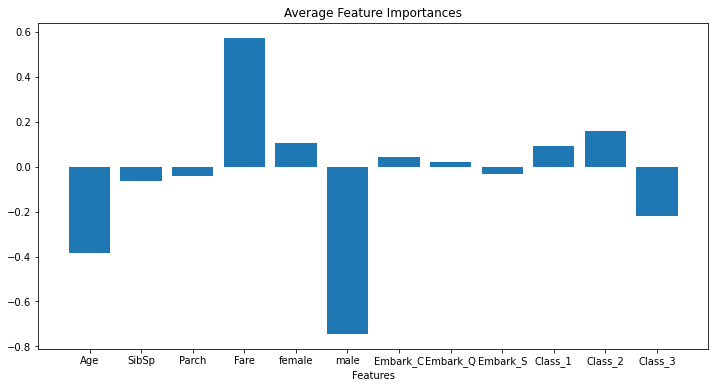

In [10]:
# Helper method to print importances and visualize distribution
def visualize_importances(feature_names, importances, title='Average Feature Importances', plot=True, axis_title='Features'):
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ': ', '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(12,6))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names, wrap=True)
        plt.xlabel(axis_title)
        plt.title(title)

visualize_importances(feature_names, np.mean(attr, axis=0))

### Insights

<ul>
<li>Age, fare and being male are important features which are negatively correlated with survival</li>
<li>Embarking and number of parents appears to be less important features</li>
</ul>

Note: average attribution over all the test set does not necessarily capture all information regarding feature importances

Text(0.5, 1.0, 'Distribution of SibSp attribution values')

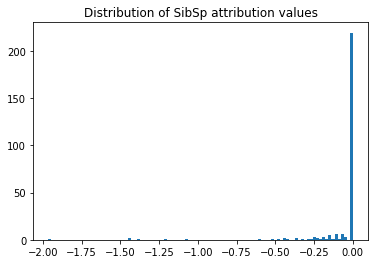

In [11]:
# Looking at the attribution of single example (number of siblings)

plt.hist(attr[:,1], 100)
plt.title('Distribution of SibSp attribution values')

In [12]:
# 2. What is the contribution of each neuron in a given layer?

# Layer attributions
cond = LayerConductance(net, net.sigmoid1)
cond_vals = cond.attribute(test_input_tensor, target=1)
cond_vals = cond_vals.detach().numpy()

Average Neuron Importances
0 :  0.027
1 :  -0.094
2 :  0.131
3 :  0.058
4 :  -0.215
5 :  -0.047
6 :  -0.503
7 :  -0.019
8 :  0.104
9 :  0.065
10 :  -0.067
11 :  0.071


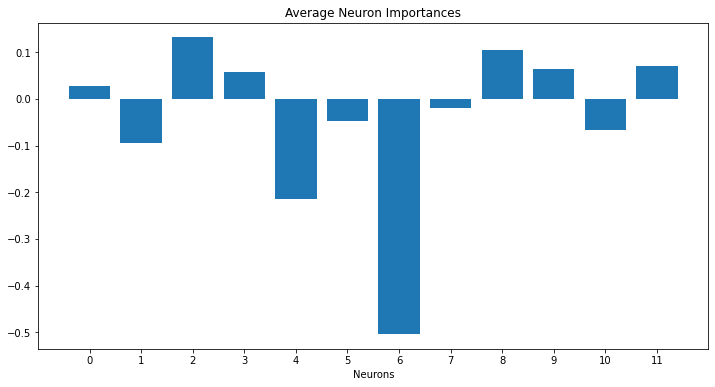

In [13]:
visualize_importances(range(12), np.mean(cond_vals, axis=0), title='Average Neuron Importances', axis_title='Neurons')

Average Feature Importances for Neuron 4
Age :  -0.185
SibSp :  0.017
Parch :  -0.013
Fare :  0.136
female :  0.012
male :  -0.139
Embark_C :  0.015
Embark_Q :  -0.000
Embark_S :  -0.015
Class_1 :  0.006
Class_2 :  0.010
Class_3 :  -0.041


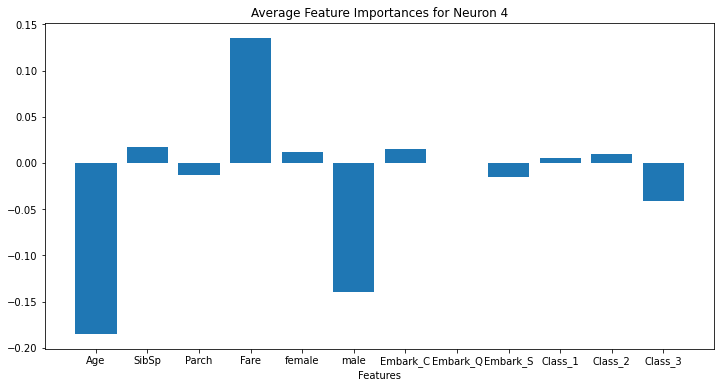

In [14]:
# 3. Which feature is activating particular neuron? Is it single feature or multiple feature?

# Neuron total conductance divides the neuron's total conductance value into contributions from each individual input feature
neuron_cond = NeuronConductance(net, net.sigmoid1)
neuron_cond_vals_4 = neuron_cond.attribute(test_input_tensor, neuron_selector=4, target=1)
neuron_cond_vals_6 = neuron_cond.attribute(test_input_tensor, neuron_selector=6, target=1)
visualize_importances(feature_names, neuron_cond_vals_4.mean(dim=0).detach().numpy(), title='Average Feature Importances for Neuron 4')

Average Feature Importances for Neuron 6
Age :  -0.348
SibSp :  -0.051
Parch :  -0.005
Fare :  -0.020
female :  0.062
male :  -0.272
Embark_C :  0.009
Embark_Q :  0.002
Embark_S :  0.061
Class_1 :  0.083
Class_2 :  0.093
Class_3 :  -0.093


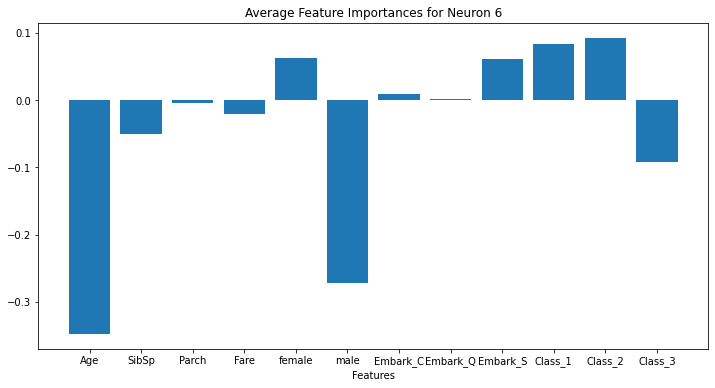

In [16]:
visualize_importances(feature_names, neuron_cond_vals_6.mean(dim=0).detach().numpy(), title='Average Feature Importances for Neuron 6')